# Analysis of GLM fits

Data from Ballinger et al., 2023. 

In [1]:
import numpy as np
import pandas as pd
import itertools
import scipy.stats as stats
from scipy.stats import pearsonr


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot



# colors
import matplotlib.colors as mcolors
import colorsys

def lighten_color(color, factor=1.7):
    """Lightens color."""
    rgb = mcolors.to_rgb(color)  
    h, l, s = colorsys.rgb_to_hls(*rgb) 
    l = min(1.0, l * factor) 
    new_rgb = colorsys.hls_to_rgb(h, l, s)  
    return new_rgb


c_p1 = 'steelblue'
c_p2 = 'orange'
c_h1 = lighten_color(c_p1)
c_h2 = lighten_color(c_p2)

fs = 20

/home/maria/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def get_fdrs(pvals):
    ''' Correct raw p-values by Benjamini-Hochberg.'''

    num_test = len(pvals)
    sorted_index = np.argsort(np.argsort(pvals))
    fdr = (np.arange(1,num_test+1)/num_test * sorted(pvals))[sorted_index]

    return(fdr)

def scatter_plot(x, y, 
                        point_alpha=0.3, point_edge_color='black', point_edge_width=0.5,
                        above_color='blue', below_color='red',
                        grid_color='lightgray', grid_alpha=0.8,
                        title="Scatter Plot", xlabel="X-axis", 
                        ylabel="Y-axis",
                        figsize=(8, 8),
                        logscale=False,
                        line='Identity',
                        above_line=[],
                        below_line=[]):
    fig, ax = plt.subplots(figsize=figsize)
    
    # Determine identity line limits
    min_val = min([np.min(x), np.min(y)])
    max_val = max([np.max(x), np.max(y)])
    
    # Add identity line
    if line == "Identity":
        ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label="Identity Line")
    else:
        plt.axhline(y=0)
    
    if len(above_line)==0:
        above_line = y>x
    if len(below_line)==0:
        below_line=~above_line
    # Scatter points
    ax.scatter(x[above_line], y[above_line], color=above_color, edgecolor=point_edge_color, alpha=point_alpha, linewidth=point_edge_width,
                label=f"DESeq2 $>$ EdgeR ({sum(above_line)})")
    ax.scatter(x[below_line], y[below_line], color=below_color, edgecolor=point_edge_color, alpha=point_alpha, linewidth=point_edge_width,
                label=f"DESeq2 $\leq$ EdgeR ({sum(below_line)})")
    
    # Grid and aesthetics
    ax.grid(color=grid_color, alpha=grid_alpha)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Adjust axis limits
    # ax.set_xlim(1.1*min_val, 1.1*max_val)
    # ax.set_ylim(1.1*min_val, 1.1*max_val)
    
    # Add legend
    ax.legend(fontsize=10)

    # scale 
    if logscale:
        plt.xscale('log')
        plt.yscale('log')   
    
    # Show the plot
    plt.tight_layout()
    plt.show()


def plot_reg_bar(reg_assignments,title,ylim):
    
    # number per category
    reg_groups = ['cis & trans','trans', 'cis', 'conserved']
    bar_colors = ['lightseagreen','royalblue','orangered','lightgray']
    
    num_per_reg_group = [ np.sum(reg_assignments=='cis&trans'),
                          np.sum(reg_assignments=='trans'),
                          np.sum(reg_assignments=='cis'),
                          np.sum(reg_assignments=='conserved') ]
    
    # barplot

    fig, ax = plt.subplots(1,1,figsize = (8,6) )

    axis_fs = 20
    title_fs = 20
    ax.set_ylim(0,ylim)
    bars = ax.bar(range(len(num_per_reg_group)), num_per_reg_group, color=bar_colors)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}',
                ha='center', va='bottom', fontsize=25)

    ax.set_xticks(range(len(num_per_reg_group)))
    ax.set_xticklabels(reg_groups,fontsize=axis_fs-4,rotation=45,ha='right')
    ax.set_xlabel('Assigned regulation group',fontsize=axis_fs)
    ax.set_ylabel('Number of genes',fontsize= axis_fs)
    # ax.set_yscale('log')
    ax.yaxis.grid(which='both', alpha=0.5, linewidth=0.5)
    ax.minorticks_on()
    ax.xaxis.set_tick_params(which='minor', bottom=False)
    ax.set_title(title,fontsize=title_fs)

    plt.show();








In [3]:
# load in data
actual_values = pd.read_csv(f'../data/ballinger/male_LiverBAT_warmcold_X.txt',delimiter='\t',header=None).T

# gene names
gene_names_raw1 = pd.read_csv("../data/ballinger/gProfiler_gene_names_1.csv")
gene_names_raw = pd.read_csv("../data/ballinger/gProfiler_gene_names.csv")
# concatenate
gene_names_df = pd.concat((gene_names_raw1,gene_names_raw)).sort_values(by='name',ascending=True)
gene_names = np.sort(gene_names_df.name.values)


full_model_coefficients = [r"$\beta$", r"$\beta_{C}$", r"$\beta_{T1}$", r"$\beta_{T2}$",
              r"$\beta_{CO}$", r"$\beta_{T1O}$", r"$\beta_{T2O}$",
              r"$\beta_{CE}$", r"$\beta_{T1E}$", r"$\beta_{T2E}$",
              r"$\beta_{O}$", r"$\beta_{E}$", r"$\beta_{OE}$",
              r"$\beta_{COE}$", r"$\beta_{T1OE}$", r"$\beta_{T2OE}$"]

In [5]:
results_dict = {"FULL_MODEL" : {}}


# load in FULL model results
results_path = f'../results/ballinger/male_LiverBAT_warmcold_'
int = "int"


null_ = "FULL_MODEL"
results_dict[null_]['fitted_values'] = pd.read_csv(f'{results_path}edgeR_{int}_FULL_fitted_vals.csv')
results_dict[null_]['coefficients'] = pd.read_csv(f'{results_path}edgeR_{int}_FULL_coefficients.csv')
results_dict[null_]['logLik'] = pd.read_csv(f'{results_path}edgeR_{int}_FULL_logLik.csv')

# create synthetic predictions using arbitrary sample size
cell_size = 1200
design_matrix_full_ = pd.read_csv(f'../data/ballinger/male_design_model_tANDt_int_FULL.txt',sep='\t',header=None)
design_matrix_ = np.zeros((16,16))

i = 0 
for i in range(16):
    design_matrix_[i] = design_matrix_full_.iloc[i*6].values

pred_counts_ = np.array([np.sum(results_dict[null_]['coefficients'].iloc[i,:].values*design_matrix_, axis=1) + np.log(cell_size) for i in range(len(gene_names))])
pred_counts_ = np.exp(pred_counts_)

results_dict[null_]["design_matrix"] = design_matrix_
results_dict[null_]["design_matrix_full"] = design_matrix_full_
results_dict[null_]["standard_pred_counts"] = pred_counts_

In [7]:
# load in results (coefficients, fitted values, likelihood ratios)
# and calculate p-values per gene given chi-squared distribution

null_hypotheses = ["no_cis","no_trans",
                   "no_organ","no_temp","no_organ-temp",
                   "no_organ-cis","no_organ-trans",
                   "no_temp-cis","no_temp-trans",
                   "no_organ-temp-cis","no_organ-temp-trans"]

for null_ in null_hypotheses:
    results_dict[null_] = {}
    results_dict[null_]['fitted_values'] = pd.read_csv(f'{results_path}edgeR_{int}_FULL_{null_}_fitted_vals.csv')
    results_dict[null_]['coefficients'] = pd.read_csv(f'{results_path}edgeR_{int}_FULL_{null_}_coefficients.csv')
    results_dict[null_]['logLik'] = pd.read_csv(f'{results_path}edgeR_{int}_FULL_{null_}_logLik.csv')

    results_dict[null_]['LR'] =  2*(results_dict["FULL_MODEL"]["logLik"].x.values - results_dict[null_]["logLik"].x.values)
    n_coef_ = results_dict[null_]['coefficients'].shape[1]
    print(null_,n_coef_)
    df_ = 16-n_coef_
    results_dict[null_]['LR_pvals'] = stats.chi2.sf(results_dict[null_]['LR'],df_)
    results_dict[null_]['fdr'] = get_fdrs(results_dict[null_]['LR_pvals'])

    # create synthetic predictions using arbitrary sample size
    design_matrix_full_ = pd.read_csv(f'../data/ballinger/male_design_model_tANDt_int_FULL_{null_}.txt',sep='\t',header=None)
    design_matrix_ = np.zeros((16,n_coef_))

    i = 0 
    for i in range(16):
        design_matrix_[i] = design_matrix_full_.iloc[i*6].values

    pred_counts_ = np.array([np.sum(results_dict[null_]['coefficients'].iloc[i,:].values*design_matrix_, axis=1) + np.log(cell_size) for i in range(len(gene_names))])
    pred_counts_ = np.exp(pred_counts_)

    results_dict[null_]["design_matrix"] = design_matrix_
    results_dict[null_]["design_matrix_full"] = design_matrix_full_
    results_dict[null_]["standard_pred_counts"] = pred_counts_

    # plt.hist(results_dict[null_]['LR_pvals'],bins=100)
    # plt.title(null_)
    # plt.show()




no_cis 12
no_trans 12
no_organ 8
no_temp 8
no_organ-temp 15
no_organ-cis 14
no_organ-trans 15
no_temp-cis 14
no_temp-trans 15
no_organ-temp-cis 14
no_organ-temp-trans 15


In [8]:
actual_values_norm = np.array(actual_values)
actual_values_norm = actual_values_norm/actual_values_norm.sum(axis=0)*cell_size
actual_values_norm.shape

# indices
# model: tissue AND temperature specific effects
p1_index = np.array( [True]*24 + [False]*72 ) 
p2_index = np.array( [False]*24 + [True]*24 + [False]*48 )
h1_index = np.array( [False]*48 + [True]*24 + [False]*24 )
h2_index = np.array( [False]*72 + [True]*24 )

tissue_index = [[True]*12+[False]*12]*4
tissue_index = np.array( [item for sublist in tissue_index for item in sublist] )

temp_index = [[True]*6+[False]*6]*8
temp_index = np.array( [item for sublist in temp_index for item in sublist] )

In [9]:
# look at top genes for each hypothesis

N = 1
nulls_to_plot = ['_','_organ-','_temp-','_organ-temp-']
genes_to_plot = []

for null_ in nulls_to_plot:
    print(null_)
    fdr_cis = results_dict[f'no{null_}cis']['fdr']
    fdr_trans = results_dict[f'no{null_}trans']['fdr']

    # find top cis ONLY genes
    filt_cis = (fdr_cis<=0.05) & (fdr_trans>0.05)
    filt_fdr_cis = fdr_cis[filt_cis]
    filt_genes_cis = gene_names[filt_cis]
    thresh_top_N = np.sort(filt_fdr_cis)[N]
    selected_fdr_cis, selected_genes_cis = filt_fdr_cis[filt_fdr_cis<=thresh_top_N], filt_genes_cis[filt_fdr_cis<=thresh_top_N]
    for g,gene in enumerate(selected_genes_cis[:N+1]):
        genes_to_plot.append(gene)

    filt_trans = (fdr_cis>0.05) & (fdr_trans<=0.05)
    filt_fdr_trans = fdr_trans[filt_trans]
    filt_genes_trans = gene_names[filt_trans]
    thresh_top_N = np.sort(filt_fdr_trans)[N]
    selected_fdr_trans, selected_genes_trans = filt_fdr_trans[filt_fdr_trans<=thresh_top_N], filt_genes_trans[filt_fdr_trans<=thresh_top_N]
    for g,gene in enumerate(selected_genes_trans[:N+1]):
        genes_to_plot.append(gene)


_
_organ-
_temp-
_organ-temp-


In [11]:
genes_to_plot = ['Rmdn3',
                 'Maff',
                 'Irak4',
                 'Cpsf6',
                 'Slc45a4',
                 'Zfp568',
                 ]

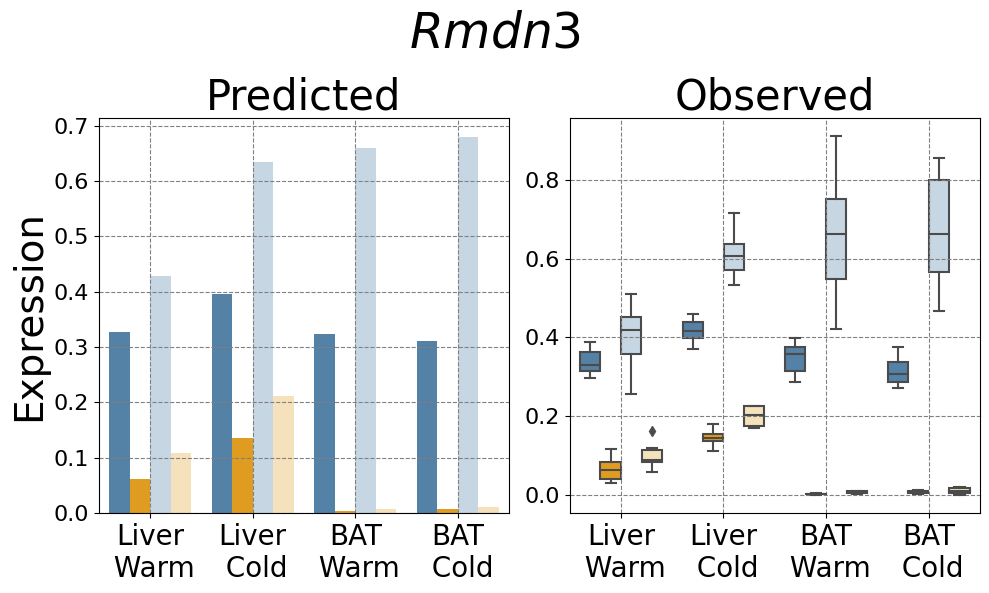

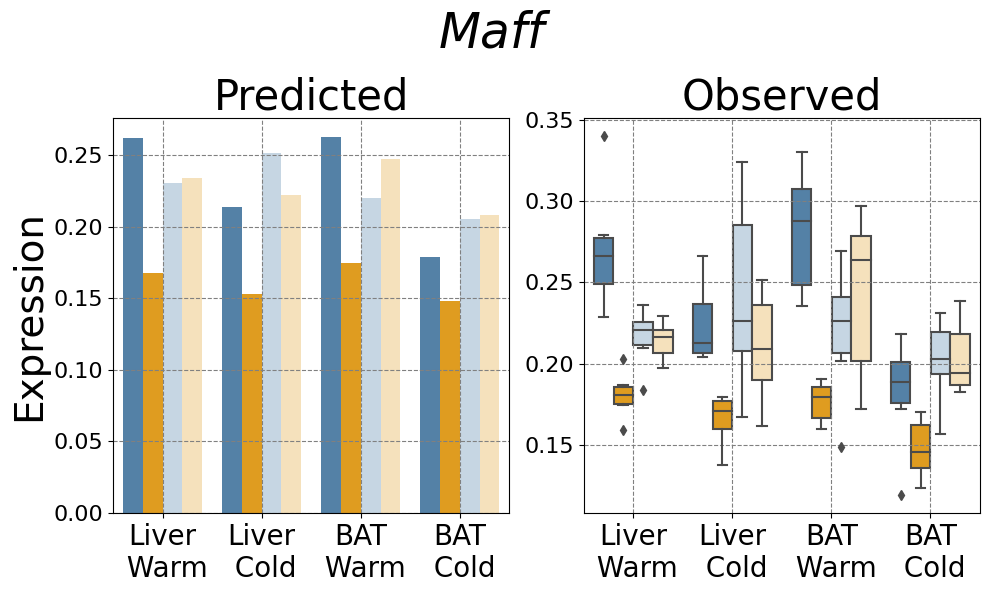

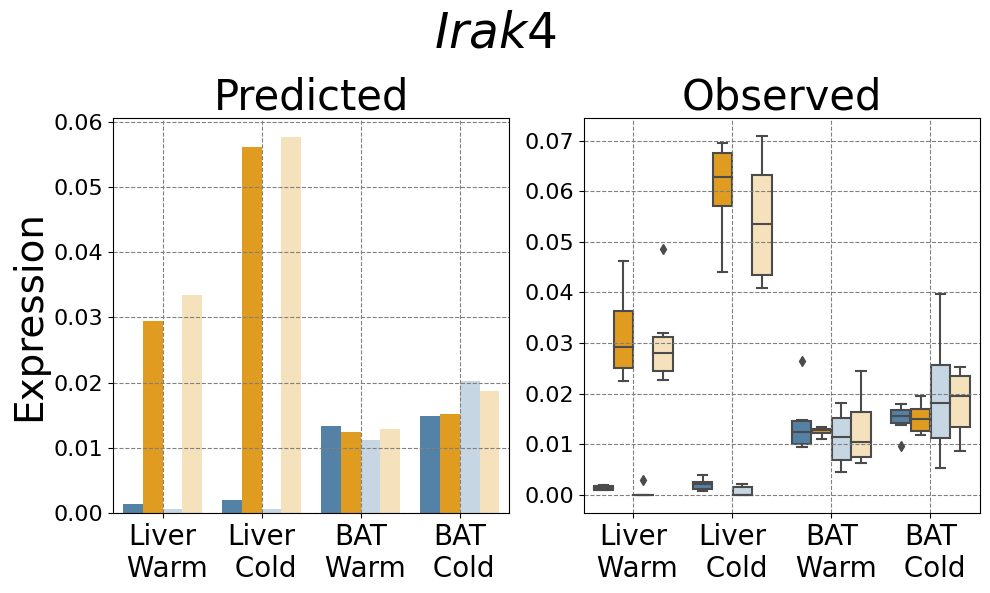

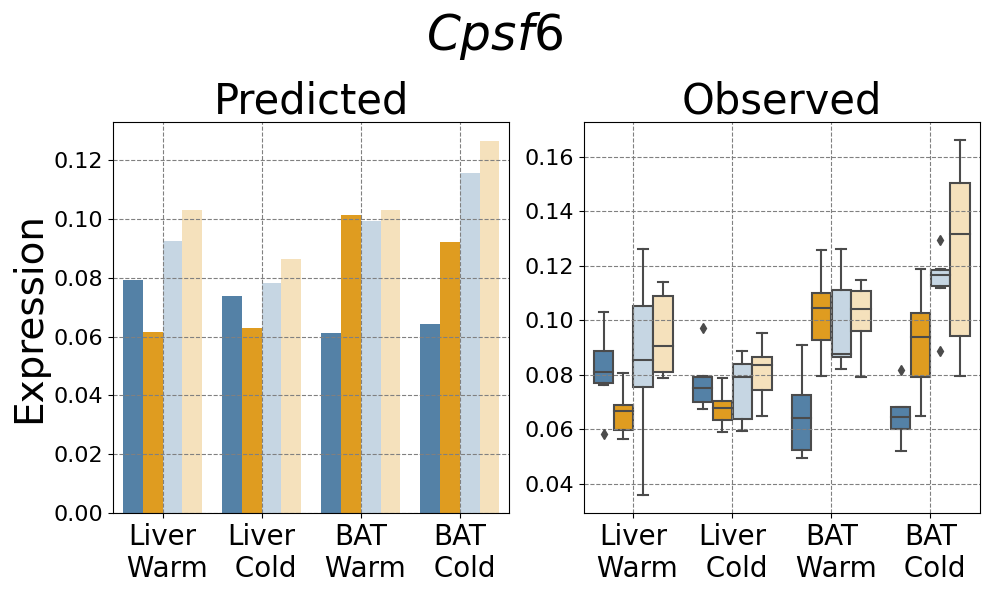

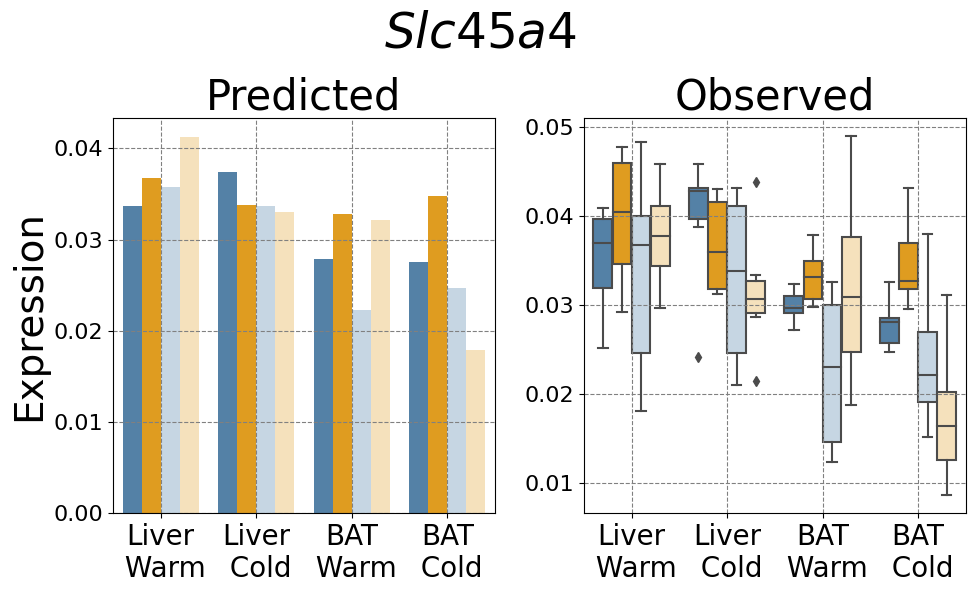

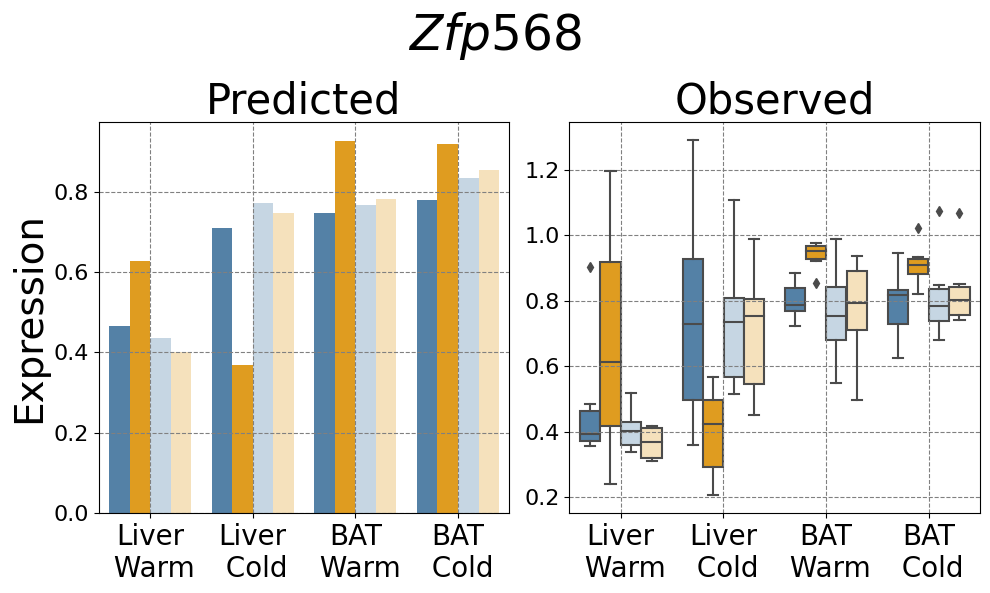

In [12]:
fs_title = 30
fs_suptitle = 35
fs_label = 28
fs_xtick = 20
fs_ytick = 16


for g,gene in enumerate(genes_to_plot):
    g_index = np.where(gene_names==gene)[0][0]
    values = results_dict["FULL_MODEL"]["standard_pred_counts"][g_index]

    categories = ["X_P1"]*4+["X_P2"]*4+["X_H1"]*4+["X_H2"]*4

    supergroups = ["Liver\n Warm", "Liver\n Cold", "BAT\n Warm", "BAT\n Cold"]*4

    df = pd.DataFrame({
        "Expression": values,
        "Sample": categories,
        "Tissue-Env": supergroups
    })

    supergroup_colors = {
        "X_P1": c_p1,
        "X_P2": c_p2,
        "X_H1": c_h1,
        "X_H2": c_h2,
    }

    df["Color"] = df["Sample"].map(supergroup_colors)

    fig,axes = plt.subplots(1,2,figsize=(10, 6))

    sns.barplot(
        data=df,
        x="Tissue-Env",
        y="Expression",
        hue="Sample",
        palette=df["Color"].unique(),
        ax = axes[0]
    )


    gene_counts_ = actual_values.iloc[g_index,:].values
    gene_counts_norm_ = actual_values_norm[g_index]

    df_gene_plot_ = {}

    condition_array = np.array(['']*96)
    allele_array =  np.array(['']*96)

    df_gene_plot_["Condition"]=condition_array
    df_gene_plot_["Allele"]=allele_array
    df_gene_plot_["Counts"]=gene_counts_
    df_gene_plot_["Normalized_Counts"]=gene_counts_norm_

    df_gene_plot_ = pd.DataFrame(df_gene_plot_)

    df_gene_plot_.loc[p1_index,"Allele"] = 'P1'
    df_gene_plot_.loc[p2_index,"Allele"] = 'P2'
    df_gene_plot_.loc[h1_index,"Allele"] = 'H1'
    df_gene_plot_.loc[h2_index,"Allele"] = 'H2'

    df_gene_plot_.loc[(tissue_index&temp_index),"Condition"]='Liver\n Warm'
    df_gene_plot_.loc[tissue_index&~temp_index,"Condition"]='Liver\n Cold'
    df_gene_plot_.loc[~tissue_index&temp_index,"Condition"]='BAT\n Warm'
    df_gene_plot_.loc[~tissue_index&~temp_index,"Condition"]='BAT\n Cold'

    sns.boxplot(data=df_gene_plot_,
            x='Condition',
            y='Normalized_Counts',
            hue='Allele',
            palette=df["Color"].unique(),
            ax=axes[1])
    

    # axes[0].set_title('Predicted',fontsize=fs_title)
    # axes[1].set_title('Observed',fontsize=fs_title)

    axes[0].set_xlabel("",fontsize=fs_label)
    axes[0].set_ylabel("Expression",fontsize=fs_label)

    axes[1].set_xlabel("",fontsize=fs_label)
    axes[1].set_ylabel("",fontsize=fs_label)


    axes[0].grid(linestyle='--',color='gray')
    axes[1].grid(linestyle='--',color='gray')
    axes[0].legend().remove()
    axes[1].legend().remove()

    axes[0].tick_params(axis="x", labelsize=fs_xtick)
    axes[1].tick_params(axis="x", labelsize=fs_xtick)

    axes[0].tick_params(axis="y", labelsize=fs_ytick)
    axes[1].tick_params(axis="y", labelsize=fs_ytick)


    axes[0].set_title("Predicted",fontsize=fs_title)
    axes[1].set_title("Observed",fontsize=fs_title)

    plt.suptitle(f'${gene}$',fontsize=fs_suptitle)

    plt.tight_layout()
    plt.show();


In [13]:
# heat map


coef_df = results_dict['FULL_MODEL']['coefficients']
coef_df['gene_name'] = gene_names
coef_df = coef_df.set_index(gene_names)



/tmp/ipykernel_1795247/2439716128.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  heatmap_weights = np.array(coef_df.loc[genes_to_plot].values[:,1:-1],dtype=np.float)


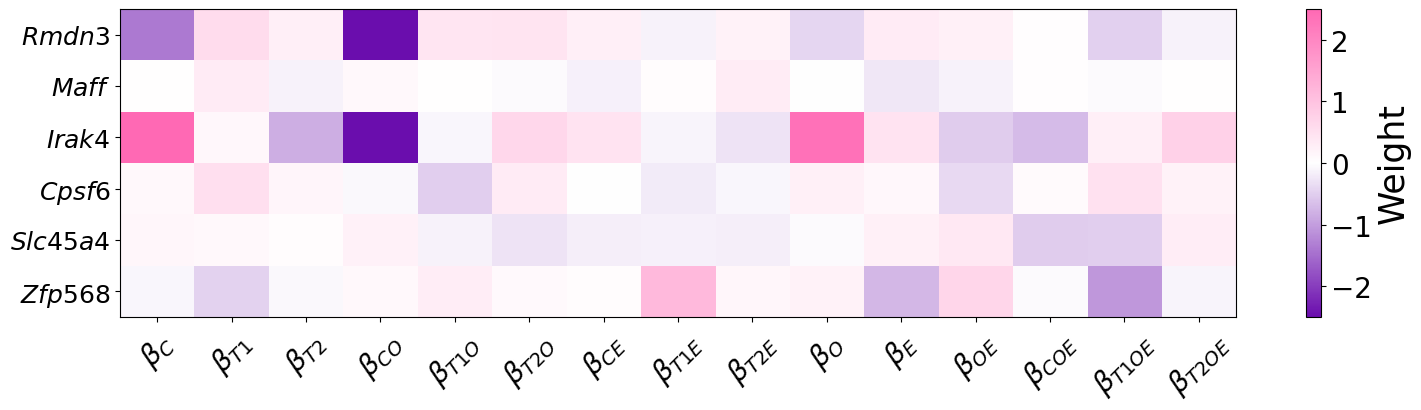

In [14]:
# heat map

colors = [
    (0.0, "#6a0dad"),
    (0.5, "#ffffff"), 
    (1.0, "#ff69b4"),
]

custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("PurpleWhitePink", colors, N=256)

fig,ax = plt.subplots(figsize = (18,4))
heatmap_weights = np.array(coef_df.loc[genes_to_plot].values[:,1:-1],dtype=np.float) 
im = ax.imshow(heatmap_weights,cmap=custom_cmap,aspect='auto',vmax=2.5,vmin=-2.5)


# labels
x_positions = range(15)
y_positions = range(len(genes_to_plot))
x_labels = full_model_coefficients[1:]
y_labels = [f'${g}$' for g in genes_to_plot]

ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, fontsize=20,rotation=45)

ax.set_yticks(y_positions)
ax.set_yticklabels(y_labels, fontsize=18)


# add color bar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Weight", fontsize=25)
cbar.ax.tick_params(labelsize=20);

# EdgeR vs. DESeq2 Results: Male, Bat, Cold

In [16]:
assigned_bat_cold = pd.read_csv('../data/ballinger/BAT.MALE.COLD.categories.forplot.txt',sep=' ')
assigned_bat_cold = assigned_bat_cold.set_index( 'Unnamed: 0' )
genes_bat_cold = np.sort(assigned_bat_cold.index.values)
assigned_bat_cold = assigned_bat_cold.loc[ genes_bat_cold, :]

In [18]:
# load in edgeR pvals and likelihoods
results_dict_edgeR  = {"FULL_MODEL" : {}, "_no_cis": {}, "_no_trans" : {}} 

results_path_edgeR = '../results/ballinger/male_BAT_cold_'

pval_name = 'pvals'
results_dict_edgeR["_no_cis"]["LR_pvals"] = pd.read_csv(f'{results_path_edgeR}edgeR_{pval_name}_no_cis.csv').iloc[:,0].values
results_dict_edgeR["_no_trans"]["LR_pvals"]  = pd.read_csv(f'{results_path_edgeR}edgeR_{pval_name}_no_trans.csv').iloc[:,0].values

results_dict_edgeR["_no_cis"]["fdr"] = get_fdrs(results_dict_edgeR["_no_cis"]["LR_pvals"])
results_dict_edgeR["_no_trans"]["fdr"] = get_fdrs(results_dict_edgeR["_no_trans"]["LR_pvals"])


results_dict_edgeR["FULL_MODEL"]["fitted_values"]  = pd.read_csv(f'{results_path_edgeR}edgeR_fitted_vals.csv')
results_dict_edgeR["FULL_MODEL"]["coefficients"] = pd.read_csv(f'{results_path_edgeR}edgeR_coefficients.csv')
results_dict_edgeR["FULL_MODEL"]["logLik"] = pd.read_csv(f'{results_path_edgeR}edgeR_logLik.csv')
results_dict_edgeR["FULL_MODEL"]["dispersions"] = pd.read_csv(f'{results_path_edgeR}edgeR_dispersions.csv')


In [25]:
results_dict_deseq2 = {"FULL_MODEL" : {}}

# load in FULL model results
results_path_deseq2 = f'../results/ballinger/male_'
tissue = "BAT"
temp = "cold"
null_ = ""
results_dict_deseq2["FULL_MODEL"]['fitted_values'] = pd.read_csv(f'{results_path_deseq2}{tissue}_{temp}_deseq2{null_}_fitted_vals.csv')
results_dict_deseq2["FULL_MODEL"]['coefficients'] = pd.read_csv(f'{results_path_deseq2}{tissue}_{temp}_deseq2{null_}_coefficients.csv')
results_dict_deseq2["FULL_MODEL"]['logLik'] = pd.read_csv(f'{results_path_deseq2}{tissue}_{temp}_deseq2{null_}_logLik.csv')
results_dict_deseq2["FULL_MODEL"]['dispersions'] = pd.read_csv(f'{results_path_deseq2}{tissue}_{temp}_deseq2{null_}_dispersions.csv')

In [26]:
for null_ in ["_no_cis","_no_trans"]:
    results_dict_deseq2[null_] = {}
    results_dict_deseq2[null_]['fitted_values'] = pd.read_csv(f'{results_path_deseq2}{tissue}_{temp}_deseq2{null_}_fitted_vals.csv')
    results_dict_deseq2[null_]['coefficients'] = pd.read_csv(f'{results_path_deseq2}{tissue}_{temp}_deseq2{null_}_coefficients.csv')
    results_dict_deseq2[null_]['logLik'] = pd.read_csv(f'{results_path_deseq2}{tissue}_{temp}_deseq2{null_}_logLik.csv')
    results_dict_deseq2[null_]['LR'] =  2*(results_dict_deseq2["FULL_MODEL"]["logLik"].x.values - results_dict_deseq2[null_]["logLik"].x.values)
    n_coef_ = results_dict_deseq2[null_]['coefficients'].shape[1]
    print(null_,n_coef_)
    df_ = 4-n_coef_
    print(df_)
    results_dict_deseq2[null_]['LR_pvals'] = stats.chi2.sf(results_dict_deseq2[null_]['LR'],df_)
    results_dict_deseq2[null_]['fdr'] = get_fdrs(results_dict_deseq2[null_]['LR_pvals'])



    # plt.hist(results_dict_deseq2[null_]['fdr'],bins=100)
    # plt.title(null_+' DESeq2')
    # plt.show()

_no_cis 3
1
_no_trans 3
1


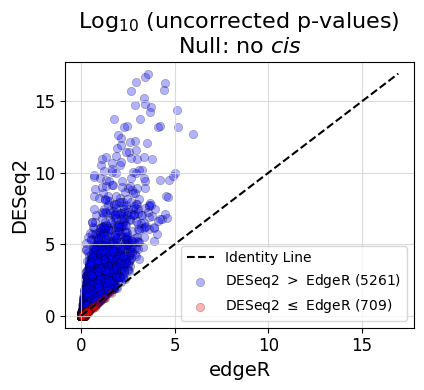

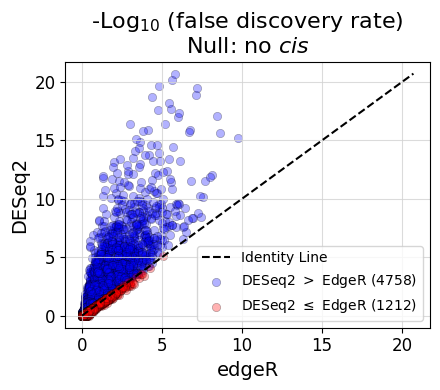

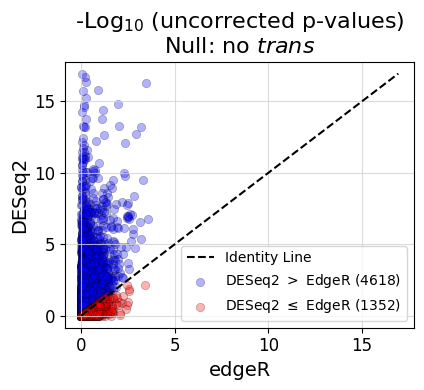

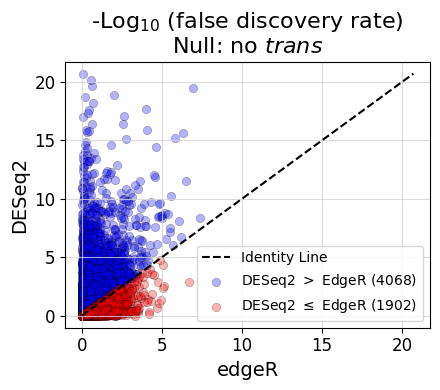

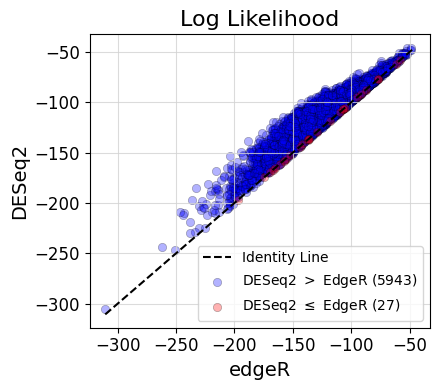

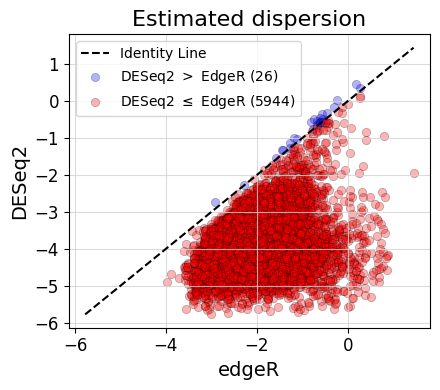

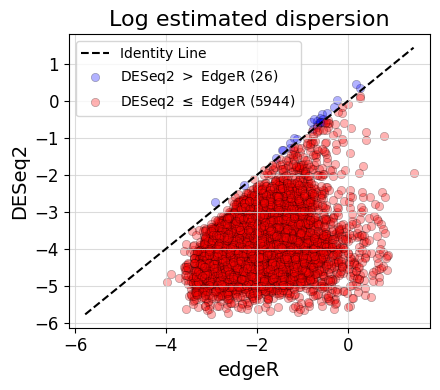

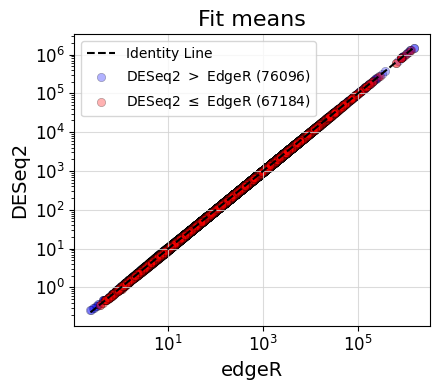

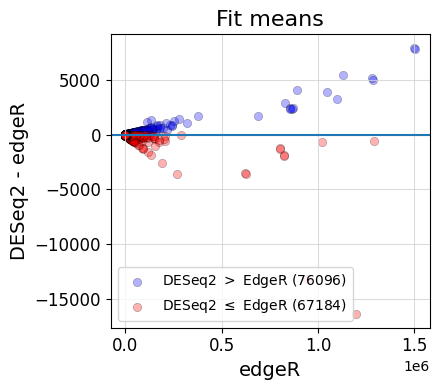

In [27]:
figsize = (4.5,4)
x,y = results_dict_edgeR["_no_cis"]["LR_pvals"],results_dict_deseq2["_no_cis"]["LR_pvals"]
x,y = -np.log10(x),-np.log10(y)
scatter_plot(x,y,
                    xlabel="edgeR",ylabel="DESeq2",
                    title="Log$_{10}$ (uncorrected p-values) \nNull: no $cis$",
                    figsize=figsize)

x,y = results_dict_edgeR["_no_cis"]["fdr"],results_dict_deseq2["_no_cis"]["fdr"]
x,y = -np.log10(x),-np.log10(y)
scatter_plot(x,y,
                    xlabel="edgeR",ylabel="DESeq2",
                    title="-Log$_{10}$ (false discovery rate)\nNull: no $cis$",
                    figsize=figsize)


x,y = results_dict_edgeR["_no_trans"]["LR_pvals"],results_dict_deseq2["_no_cis"]["LR_pvals"]
x,y = -np.log10(x),-np.log10(y)
scatter_plot(x,y,
                    xlabel="edgeR",ylabel="DESeq2",
                    title="-Log$_{10}$ (uncorrected p-values)\nNull: no $trans$",
                    figsize=figsize)

x,y = results_dict_edgeR["_no_trans"]["fdr"],results_dict_deseq2["_no_cis"]["fdr"]
x,y = -np.log10(x),-np.log10(y)
scatter_plot(x,y,
                    xlabel="edgeR",ylabel="DESeq2",
                    title="-Log$_{10}$ (false discovery rate)\nNull: no $trans$",
                    figsize=figsize)


x,y = results_dict_edgeR["FULL_MODEL"]["logLik"].x.values,results_dict_deseq2["FULL_MODEL"]["logLik"].x.values
scatter_plot(x,y,
                    xlabel="edgeR",ylabel="DESeq2",
                    title=f"Log Likelihood",
                    figsize=figsize)

x,y = results_dict_edgeR["FULL_MODEL"]["dispersions"].x.values,results_dict_deseq2["FULL_MODEL"]["dispersions"].x.values
x,y = np.log(x),np.log(y)
scatter_plot(x,y,
                    xlabel="edgeR",ylabel="DESeq2",
                    title=f"Estimated dispersion",
                    figsize=figsize)

x,y = results_dict_edgeR["FULL_MODEL"]["dispersions"].x.values,results_dict_deseq2["FULL_MODEL"]["dispersions"].x.values
x,y = np.log(x),np.log(y)
scatter_plot(x,y,
                    xlabel="edgeR",ylabel="DESeq2",
                    title=f"Log estimated dispersion",
                    figsize=figsize)

x,y = results_dict_edgeR["FULL_MODEL"]["fitted_values"].values.flatten(),results_dict_deseq2["FULL_MODEL"]["fitted_values"].values.flatten()

scatter_plot(x,y,
                    xlabel="edgeR",ylabel="DESeq2",
                    title=f"Fit means",
                    figsize=figsize,
                    logscale=True)

scatter_plot(x,(y-x),
                    xlabel="edgeR",ylabel="DESeq2 - edgeR",
                    title=f"Fit means",
                    figsize=figsize,
                    logscale=False,
                    line=0,
                    above_line=y>x,
                    below_line=~(y>x)
                    )

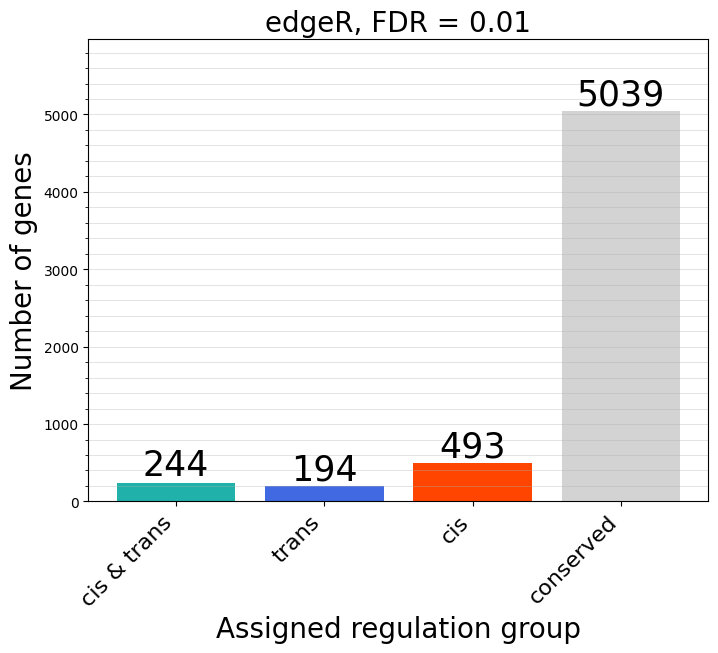

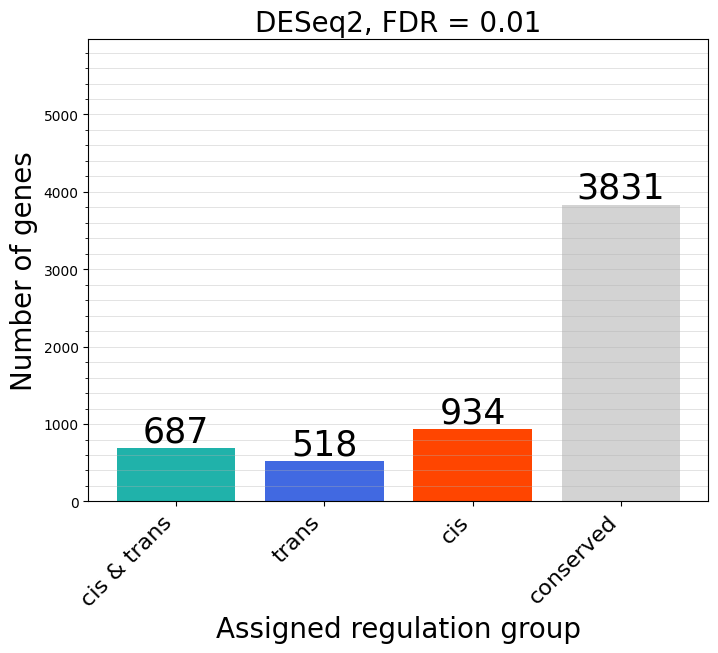

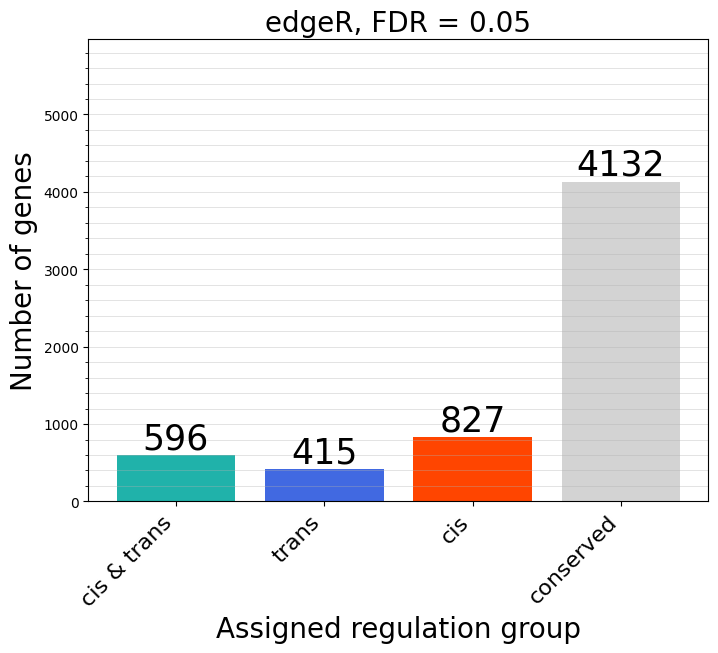

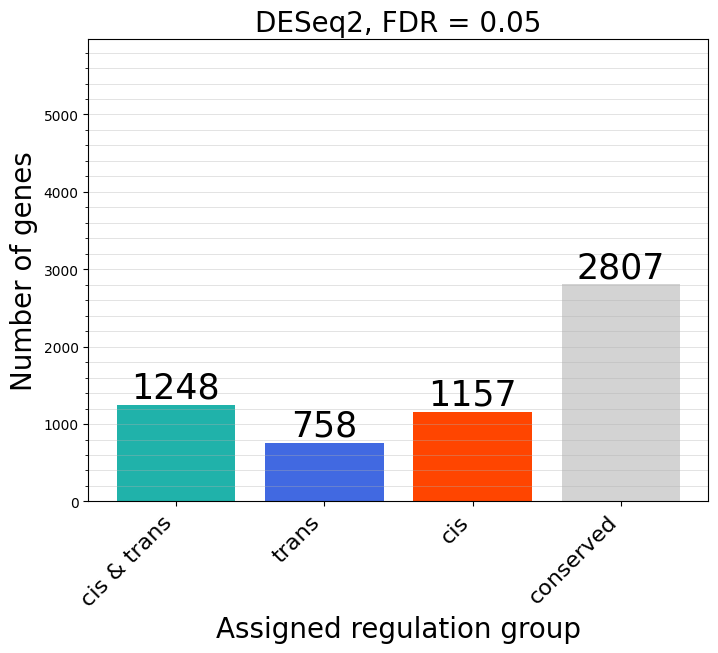

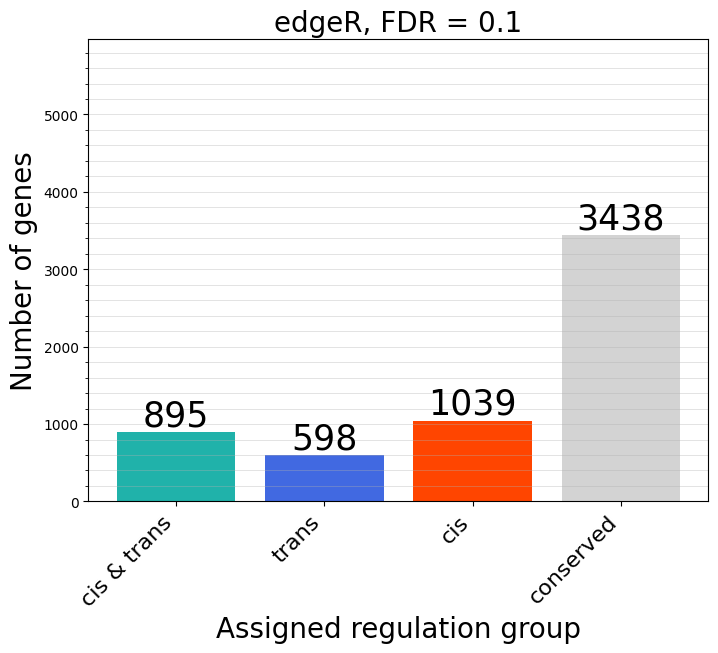

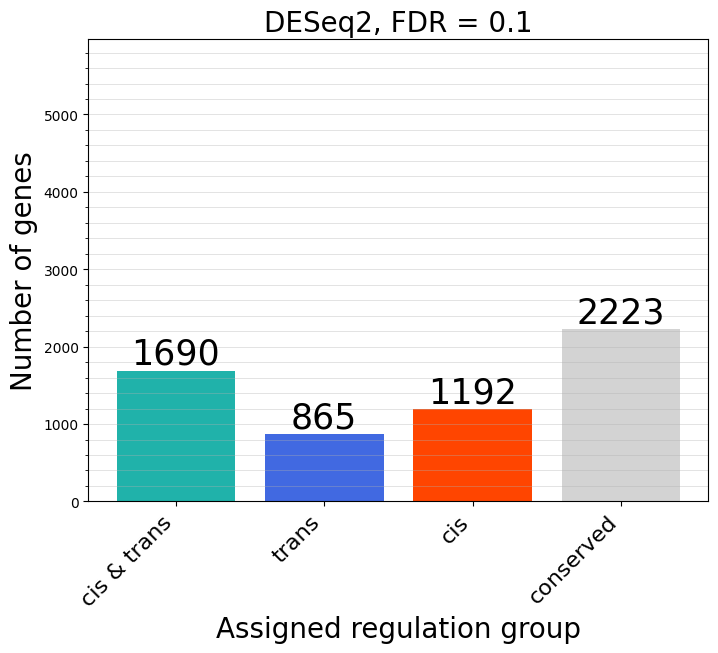

In [30]:
# how does this change the regulatory assignments
fdr_no_cis_deseq2 = results_dict_deseq2["_no_cis"]["fdr"]
fdr_no_trans_deseq2 = results_dict_deseq2["_no_trans"]["fdr"]
fdr_no_cis_edgeR = results_dict_edgeR["_no_cis"]["fdr"]
fdr_no_trans_edgeR = results_dict_edgeR["_no_trans"]["fdr"]


p_thresh = [0.01,0.05,0.1]

for p_ in p_thresh:
    fdr_no_cis = fdr_no_cis_edgeR
    fdr_no_trans = fdr_no_trans_edgeR
    # edgeR 
    cis_index = (fdr_no_cis <= p_) & (fdr_no_trans > p_)
    trans_index = (fdr_no_cis > p_) & (fdr_no_trans <= p_)
    amb_index = (fdr_no_cis > p_) & (fdr_no_trans > p_)
    cistrans_index = (fdr_no_cis <= p_) & (fdr_no_trans <= p_) 


    reg_assignments = np.array(['conserved']*len(fdr_no_cis_deseq2))

    reg_assignments[   cis_index   ] = 'cis'
    reg_assignments[   trans_index   ] = 'trans'
    reg_assignments[   cistrans_index   ] = 'cis&trans'


    plot_reg_bar(reg_assignments=reg_assignments,
                 title=f'edgeR, FDR = {p_}',
                 ylim=len(reg_assignments))

    fdr_no_cis = fdr_no_cis_deseq2
    fdr_no_trans = fdr_no_trans_deseq2

    # DESeq2
    cis_index = (fdr_no_cis <= p_) & (fdr_no_trans > p_)
    trans_index = (fdr_no_cis > p_) & (fdr_no_trans <= p_)
    amb_index = (fdr_no_cis > p_) & (fdr_no_trans > p_)
    cistrans_index = (fdr_no_cis <= p_) & (fdr_no_trans <= p_) 


    reg_assignments = np.array(['conserved']*len(fdr_no_cis_deseq2))

    reg_assignments[   cis_index   ] = 'cis'
    reg_assignments[   trans_index   ] = 'trans'
    reg_assignments[   cistrans_index   ] = 'cis&trans'


    plot_reg_bar(reg_assignments=reg_assignments,
                 title=f'DESeq2, FDR = {p_}',
                 ylim = len(reg_assignments))


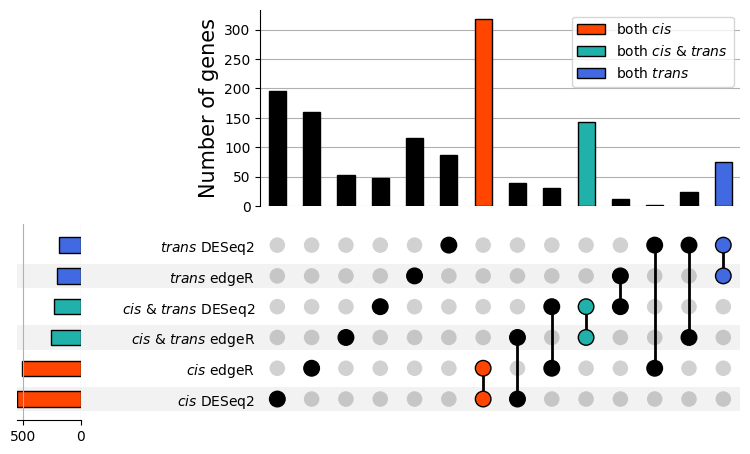

In [31]:
# upset plot for 5,000 genes
p_edgeR = 0.0112
p_deseq2 = 0.000263

cis_index_edgeR = (fdr_no_cis_edgeR <= p_edgeR ) & (fdr_no_trans_edgeR > p_edgeR )
trans_index_edgeR = (fdr_no_cis_edgeR > p_edgeR ) & (fdr_no_trans_edgeR <= p_edgeR )
amb_index_edgeR = (fdr_no_cis_edgeR > p_edgeR ) & (fdr_no_trans_edgeR > p_edgeR )
cistrans_index_edgeR = (fdr_no_cis_edgeR <= p_edgeR ) & (fdr_no_trans_edgeR <= p_edgeR ) 

cis_index_deseq2 = (fdr_no_cis_deseq2 <= p_deseq2 ) & (fdr_no_trans_deseq2 > p_deseq2 )
trans_index_deseq2 = (fdr_no_cis_deseq2 > p_deseq2 ) & (fdr_no_trans_deseq2 <= p_deseq2 )
amb_index_deseq2 = (fdr_no_cis_deseq2 > p_deseq2 ) & (fdr_no_trans_deseq2 > p_deseq2 )
cistrans_index_deseq2 = (fdr_no_cis_deseq2 <= p_deseq2 ) & (fdr_no_trans_deseq2 <= p_deseq2 ) 


gene_numbers = np.arange(len(cis_index_deseq2))
upset_dict = {'$cis$ DESeq2' : gene_numbers[cis_index_deseq2],
              '$trans$ DESeq2' : gene_numbers[trans_index_deseq2],
              '$cis$ & $trans$ DESeq2' : gene_numbers[cistrans_index_deseq2],
              '$cis$ edgeR' : gene_numbers[cis_index_edgeR],
              '$trans$ edgeR' : gene_numbers[trans_index_edgeR],
              '$cis$ & $trans$ edgeR' : gene_numbers[cistrans_index_edgeR],
              }


upset_df = upsetplot.from_contents(upset_dict)

# ['lightseagreen','royalblue','orangered','lightgray']
upset = upsetplot.UpSet(upset_df)
upset.style_categories(
    ["$cis$ DESeq2","$cis$ edgeR"], bar_facecolor="orangered",bar_edgecolor="black"
)
upset.style_categories(
    ["$trans$ DESeq2","$trans$ edgeR"], bar_facecolor="royalblue",bar_edgecolor="black"
)
upset.style_categories(
    ["$cis$ & $trans$ DESeq2","$cis$ & $trans$ edgeR"], bar_facecolor="lightseagreen",bar_edgecolor="black"
)
upset.style_subsets(present=["$cis$ edgeR", "$cis$ DESeq2"], facecolor="orangered",edgecolor="black",label="both $cis$")
upset.style_subsets(present=["$cis$ & $trans$ edgeR", "$cis$ & $trans$ DESeq2"], facecolor="lightseagreen",edgecolor="black",label="both $cis$ & $trans$")
upset.style_subsets(present=["$trans$ edgeR", "$trans$ DESeq2"], facecolor="royalblue",edgecolor="black",label="both $trans$")

upset.plot()
plt.ylabel("Number of genes",fontsize=15);